In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import torch
import hypergrad as hg
import numpy as np
import torch.nn.functional as F
#from sklearn.datasets import make_spd_matrix as spd
import time

In [2]:
torch.random.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
p, d, n = 64, 128, 500
m = 0.1 

H_true = torch.randn((p, d))
w_true = torch.randn(d)
Xg = torch.randn((n, p))
yg = Xg @ H_true @ w_true + m * torch.randn(n)
Xf = torch.randn((n, p))
yf = Xf @ H_true @ w_true + m * torch.randn(n)

In [4]:
b = 0.1

def inner_func(params, hparams):
    H = hparams[0]
    w = params[0]
    
    g =  (0.5 * (torch.norm(Xg @ H @ w - yg))**2) / n + 0.5 * b * (torch.norm(w))**2 
    return g #.squeeze()

def outer_func(params, hparams):
    
    H = hparams[0]
    w = params[0]
    
    f = (0.5 * (torch.norm(Xf @ H @ w - yf))**2) / n 
    
    return f #.squeeze()

alpha = .001
p0 = [torch.randn(d)]
hp0 = [torch.randn((p, d))]

def map_func(params, hparams):
    
    g = inner_func(params, hparams)
    #inner_losses.append(g.item())
    #print(torch.norm(torch.autograd.grad(g, params, create_graph=True)[0]))
    
    return [params[0] - alpha * torch.autograd.grad(g, params, create_graph=True)[0]]


def regressor(params, Z, y):
    w = params[0]
    loss = (torch.norm(Z @ w - y))**2
    return loss

def inner_solver(hparams, steps=100, params0=None, optim=None): 
    
    H = hparams[0] 
    Zg = Xg @ H
    
    # params = [torch.randn(d).requires_grad_(True)]
    params = [p.requires_grad_(True) for p in p0]

    for _ in range(steps):
        
        loss = 0.5 * regressor(params, Zg, yg) / n + 0.5 * b * (torch.norm(params[0]))**2 
        params = [params[0] - alpha * torch.autograd.grad(loss, params, create_graph=True)[0]]

    return params


# HOZOG

outer step=0 (3.26e-02s)(1.96e-02, 1.15e-02) | val loss=508.63787841796875 | hypergrad norm = 2.167e+00
outer step=10 (1.22e-02s)(5.67e-03, 6.43e-03) | val loss=213.6809539794922 | hypergrad norm = 5.646e-02
outer step=20 (1.24e-02s)(5.86e-03, 6.47e-03) | val loss=163.03973388671875 | hypergrad norm = 2.180e+00
outer step=30 (1.24e-02s)(5.71e-03, 6.56e-03) | val loss=118.91874694824219 | hypergrad norm = 1.051e+00
outer step=40 (1.23e-02s)(5.71e-03, 6.45e-03) | val loss=83.25920867919922 | hypergrad norm = 1.024e+00
outer step=50 (1.24e-02s)(5.78e-03, 6.51e-03) | val loss=54.973670959472656 | hypergrad norm = 4.765e-01
outer step=60 (1.23e-02s)(5.70e-03, 6.48e-03) | val loss=43.43714904785156 | hypergrad norm = 5.074e-02
outer step=70 (1.21e-02s)(5.64e-03, 6.39e-03) | val loss=29.09154510498047 | hypergrad norm = 2.861e-02
outer step=80 (1.21e-02s)(5.48e-03, 6.48e-03) | val loss=22.87594985961914 | hypergrad norm = 4.749e-01
outer step=90 (1.21e-02s)(5.69e-03, 6.35e-03) | val loss=18.7

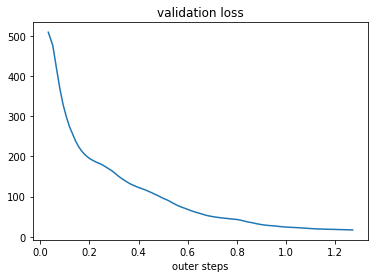

In [5]:
K = 100
eval_interval = 10
T = 20
mu = 0.01
beta = 0.1 # works better than 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hozog(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, params0=None, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))


print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

norm_hozog = hg_norms
val_hozog = val_losses
run_hozog = running_time
    

# ESJ

outer step=0 (2.68e-02s)(1.53e-02, 1.11e-02) | val loss=508.63787841796875 | hypergrad norm = 3.846e+02
outer step=10 (1.23e-02s)(5.72e-03, 6.47e-03) | val loss=5.362288951873779 | hypergrad norm = 4.107e+01
outer step=20 (1.24e-02s)(5.76e-03, 6.50e-03) | val loss=1.799433946609497 | hypergrad norm = 2.234e+01
outer step=30 (1.23e-02s)(5.71e-03, 6.47e-03) | val loss=0.8475183844566345 | hypergrad norm = 1.597e+01
outer step=40 (1.28e-02s)(6.04e-03, 6.63e-03) | val loss=0.42462608218193054 | hypergrad norm = 1.103e+01
outer step=50 (1.27e-02s)(5.80e-03, 6.72e-03) | val loss=0.15451206266880035 | hypergrad norm = 6.889e+00
outer step=60 (1.23e-02s)(5.70e-03, 6.50e-03) | val loss=0.09231806546449661 | hypergrad norm = 5.048e+00
outer step=70 (1.22e-02s)(5.69e-03, 6.43e-03) | val loss=0.06805606186389923 | hypergrad norm = 4.380e+00
outer step=80 (1.23e-02s)(5.76e-03, 6.46e-03) | val loss=0.03576812520623207 | hypergrad norm = 3.103e+00
outer step=90 (1.22e-02s)(5.68e-03, 6.44e-03) | val l

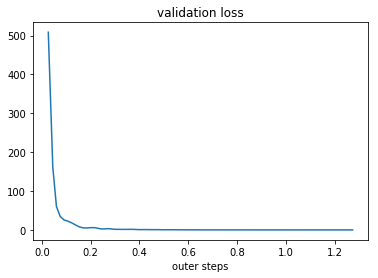

In [9]:
K = 100
eval_interval = 10
T = 20
mu = .01
beta = 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvesj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

norm_zoj = hg_norms
val_zoj = val_losses
run_zoj = running_time



# AID-FP

outer step=0 (3.26e-02s)(1.56e-02, 1.65e-02) | val loss=508.63787841796875 | hypergrad norm = 2.435e+02
outer step=10 (1.44e-02s)(5.78e-03, 8.51e-03) | val loss=10.422019004821777 | hypergrad norm = 1.657e+01
outer step=20 (1.44e-02s)(5.74e-03, 8.58e-03) | val loss=3.3422141075134277 | hypergrad norm = 9.267e+00
outer step=30 (1.43e-02s)(5.71e-03, 8.45e-03) | val loss=1.3675627708435059 | hypergrad norm = 4.755e+00
outer step=40 (1.43e-02s)(5.76e-03, 8.45e-03) | val loss=0.7099817395210266 | hypergrad norm = 2.909e+00
outer step=50 (1.42e-02s)(5.69e-03, 8.37e-03) | val loss=0.3342486023902893 | hypergrad norm = 1.416e+00
outer step=60 (1.44e-02s)(5.77e-03, 8.52e-03) | val loss=0.22853609919548035 | hypergrad norm = 1.001e+00
outer step=70 (1.42e-02s)(5.69e-03, 8.42e-03) | val loss=0.1534302979707718 | hypergrad norm = 6.573e-01
outer step=80 (1.43e-02s)(5.74e-03, 8.48e-03) | val loss=0.11572474986314774 | hypergrad norm = 3.780e-01
outer step=90 (1.43e-02s)(5.72e-03, 8.44e-03) | val lo

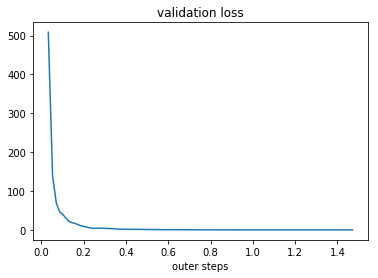

In [7]:
K = 100
eval_interval = 10
T = 20
beta = 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.fixed_point(params, hparams, T, map_func, outer_func, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

norm_fp = hg_norms
val_fp = val_losses
run_fp = running_time
    


# AID-CG

outer step=0 (3.30e-02s)(1.47e-02, 1.80e-02) | val loss=508.63787841796875 | hypergrad norm = 2.183e+02
outer step=10 (1.54e-02s)(5.88e-03, 9.45e-03) | val loss=7.099592208862305 | hypergrad norm = 2.272e+00
outer step=20 (1.54e-02s)(5.85e-03, 9.43e-03) | val loss=2.264677047729492 | hypergrad norm = 6.497e-01
outer step=30 (1.55e-02s)(5.85e-03, 9.56e-03) | val loss=0.9662903547286987 | hypergrad norm = 2.882e-01
outer step=40 (1.68e-02s)(6.32e-03, 1.03e-02) | val loss=0.45868730545043945 | hypergrad norm = 1.260e-01
outer step=50 (1.66e-02s)(6.33e-03, 1.01e-02) | val loss=0.2504042685031891 | hypergrad norm = 8.133e-02
outer step=60 (1.66e-02s)(6.22e-03, 1.02e-02) | val loss=0.1522390991449356 | hypergrad norm = 4.439e-02
outer step=70 (1.66e-02s)(6.26e-03, 1.02e-02) | val loss=0.11653198301792145 | hypergrad norm = 2.831e-02
outer step=80 (1.66e-02s)(6.24e-03, 1.02e-02) | val loss=0.09145060181617737 | hypergrad norm = 1.905e-02
outer step=90 (1.62e-02s)(6.26e-03, 9.83e-03) | val los

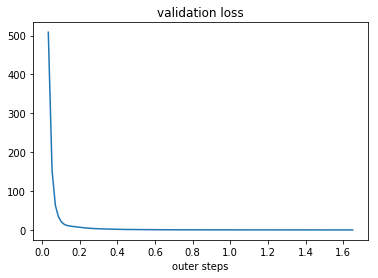

In [10]:
K = 100
eval_interval = 10
T = 20
beta = 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time, hg_norms = 0,  [], [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.CG(params, hparams, T, map_func, outer_func, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)
    hg_norms.append(torch.norm(hparams[0].grad))

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))


print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

norm_cg = hg_norms
val_cg = val_losses
run_cg = running_time


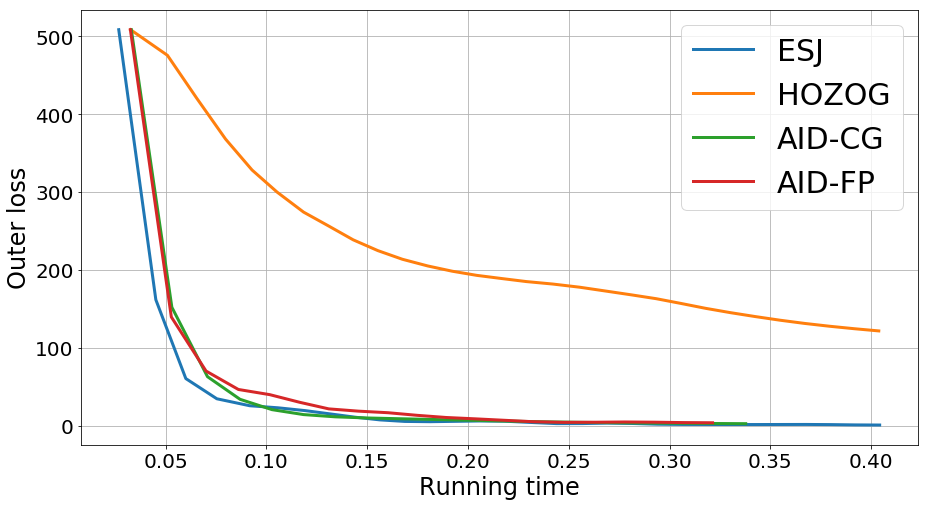

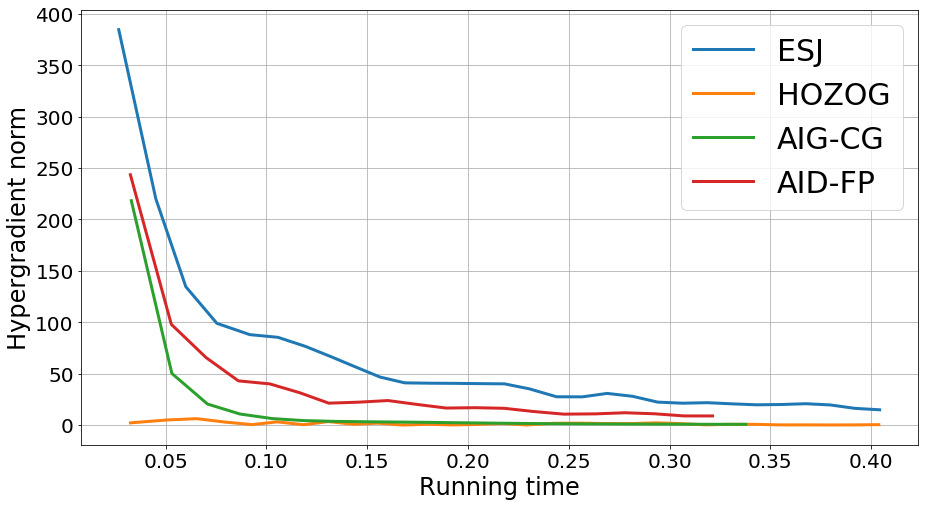

In [11]:
s, s2 = 20, 30 
lw = 3

plt.plot(run_zoj[:s2], val_zoj[:s2], '-', label='ESJ', linewidth=lw)
plt.plot(run_hozog[:s2], val_hozog[:s2], '-', label='HOZOG', linewidth=lw)
plt.plot(run_cg[:s], val_cg[:s], '-', label='AID-CG', linewidth=lw)
plt.plot(run_fp[:s], val_fp[:s], '-', label='AID-FP', linewidth=lw)
plt.xlabel('Running time', fontsize=24)
plt.ylabel('Outer loss', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(loc='upper right', fontsize=30)
plt.gcf().set_size_inches(15, 8)
plt.show()

plt.plot(run_zoj[:s2], norm_zoj[:s2], '-', label='ESJ', linewidth=lw)
plt.plot(run_hozog[:s2], norm_hozog[:s2], '-', label='HOZOG', linewidth=lw)
plt.plot(run_cg[:s], norm_cg[:s], '-', label='AIG-CG', linewidth=lw)
plt.plot(run_fp[:s], norm_fp[:s], '-', label='AID-FP', linewidth=lw)

plt.xlabel('Running time', fontsize=24)
plt.ylabel('Hypergradient norm', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='upper right', fontsize=30) #'lower right'
plt.grid()
plt.gcf().set_size_inches(15, 8)
plt.show()

# Higher Dimension

In [12]:
p, d, n = 128, 256, 1000
m = 0.1 

H_true = torch.randn((p, d))
w_true = torch.randn(d)
Xg = torch.randn((n, p))
yg = Xg @ H_true @ w_true + m * torch.randn(n)
Xf = torch.randn((n, p))
yf = Xf @ H_true @ w_true + m * torch.randn(n)

In [13]:
b = 0.1

def inner_func(params, hparams):
    H = hparams[0]
    w = params[0]
    
    g =  (0.5 * (torch.norm(Xg @ H @ w - yg))**2) / n + 0.5 * b * (torch.norm(w))**2 
    return g #.squeeze()

def outer_func(params, hparams):
    
    H = hparams[0]
    w = params[0]
    
    f = (0.5 * (torch.norm(Xf @ H @ w - yf))**2) / n 
    
    return f #.squeeze()

alpha = .001
p0 = [torch.randn(d)]
hp0 = [torch.randn((p, d))]

def map_func(params, hparams):
    
    g = inner_func(params, hparams)
    #inner_losses.append(g.item())
    #print(torch.norm(torch.autograd.grad(g, params, create_graph=True)[0]))
    
    return [params[0] - alpha * torch.autograd.grad(g, params, create_graph=True)[0]]


def regressor(params, Z, y):
    w = params[0]
    loss = (torch.norm(Z @ w - y))**2
    return loss

def inner_solver(hparams, steps=100, params0=None, optim=None): 
    
    H = hparams[0] 
    Zg = Xg @ H
    
    # params = [torch.randn(d).requires_grad_(True)]
    params = [p.requires_grad_(True) for p in p0]

    for _ in range(steps):
        
        loss = 0.5 * regressor(params, Zg, yg) / n + 0.5 * b * (torch.norm(params[0]))**2 
        params = [params[0] - alpha * torch.autograd.grad(loss, params, create_graph=True)[0]]

    return params


# def inner_solver(hparams, steps=100, params0=None, optim=None):

#     # params = [torch.randn(d).requires_grad_(True)]
#     params = [p.requires_grad_(True) for p in p0]

#     for _ in range(steps):
#         params = map_func(params, hparams)

#     return params



# ESJ

outer step=0 (4.44e-02s)(2.14e-02, 2.25e-02) | val loss=817.3919677734375 | hypergrad norm = 8.005e+02
outer step=10 (2.38e-02s)(9.26e-03, 1.43e-02) | val loss=6.810548782348633 | hypergrad norm = 5.772e+01
outer step=20 (2.29e-02s)(9.22e-03, 1.34e-02) | val loss=2.027412176132202 | hypergrad norm = 3.028e+01
outer step=30 (2.26e-02s)(8.96e-03, 1.33e-02) | val loss=0.9177627563476562 | hypergrad norm = 2.011e+01
outer step=40 (2.24e-02s)(8.92e-03, 1.32e-02) | val loss=0.34655821323394775 | hypergrad norm = 1.204e+01
outer step=50 (2.28e-02s)(9.21e-03, 1.33e-02) | val loss=0.12152007967233658 | hypergrad norm = 7.097e+00
outer step=60 (2.30e-02s)(9.06e-03, 1.35e-02) | val loss=0.08102767169475555 | hypergrad norm = 5.927e+00
outer step=70 (2.32e-02s)(9.13e-03, 1.37e-02) | val loss=0.04111432656645775 | hypergrad norm = 4.135e+00
outer step=80 (2.23e-02s)(8.85e-03, 1.32e-02) | val loss=0.017860548570752144 | hypergrad norm = 2.293e+00
outer step=90 (2.29e-02s)(9.17e-03, 1.34e-02) | val l

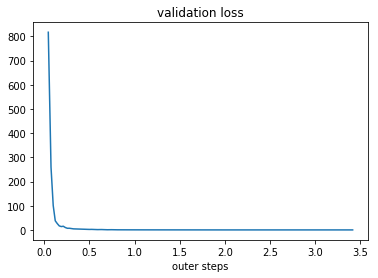

In [14]:
K = 150
eval_interval = 10
T = 20
#K = 10 
mu = .01
beta = 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time = 0,  [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvesj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

val_zoj = val_losses
run_zoj = running_time


# HOZOG 

outer step=0 (4.66e-02s)(2.52e-02, 2.10e-02) | val loss=817.3919677734375 | hypergrad norm = 5.005e-01
outer step=10 (2.36e-02s)(9.16e-03, 1.42e-02) | val loss=580.8474731445312 | hypergrad norm = 4.437e+00
outer step=20 (2.17e-02s)(8.45e-03, 1.30e-02) | val loss=313.2484130859375 | hypergrad norm = 1.129e-01
outer step=30 (2.39e-02s)(9.51e-03, 1.40e-02) | val loss=180.34234619140625 | hypergrad norm = 6.699e-01
outer step=40 (2.51e-02s)(9.35e-03, 1.53e-02) | val loss=102.7188949584961 | hypergrad norm = 4.974e-01
outer step=50 (2.43e-02s)(9.36e-03, 1.47e-02) | val loss=71.2804946899414 | hypergrad norm = 1.587e-01
outer step=60 (2.44e-02s)(9.19e-03, 1.48e-02) | val loss=53.15752029418945 | hypergrad norm = 2.945e-01
outer step=70 (2.40e-02s)(9.34e-03, 1.43e-02) | val loss=39.60078430175781 | hypergrad norm = 2.705e-01
outer step=80 (2.17e-02s)(8.51e-03, 1.29e-02) | val loss=28.083005905151367 | hypergrad norm = 2.907e-01
outer step=90 (2.52e-02s)(9.02e-03, 1.58e-02) | val loss=19.7236

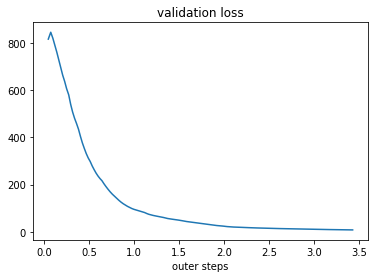

In [15]:
K = 150
eval_interval = 10
T = 20
#K = 10 
mu = 0.01
beta = 0.1

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time = 0,  [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hozog(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, params0=None, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))


print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

val_hozog = val_losses
run_hozog = running_time
    

# AID-FP

outer step=0 (4.98e-02s)(2.15e-02, 2.79e-02) | val loss=817.3919677734375 | hypergrad norm = 4.546e+02
outer step=10 (2.61e-02s)(8.96e-03, 1.69e-02) | val loss=13.180167198181152 | hypergrad norm = 2.073e+01
outer step=20 (2.64e-02s)(8.89e-03, 1.73e-02) | val loss=3.7205209732055664 | hypergrad norm = 1.001e+01
outer step=30 (2.61e-02s)(8.90e-03, 1.69e-02) | val loss=1.3588001728057861 | hypergrad norm = 5.413e+00
outer step=40 (2.62e-02s)(8.96e-03, 1.70e-02) | val loss=0.4644799530506134 | hypergrad norm = 2.736e+00
outer step=50 (2.62e-02s)(8.84e-03, 1.71e-02) | val loss=0.264379620552063 | hypergrad norm = 1.891e+00
outer step=60 (2.61e-02s)(8.91e-03, 1.70e-02) | val loss=0.15366731584072113 | hypergrad norm = 1.040e+00
outer step=70 (2.62e-02s)(8.96e-03, 1.70e-02) | val loss=0.11902781575918198 | hypergrad norm = 6.568e-01
outer step=80 (2.60e-02s)(8.89e-03, 1.69e-02) | val loss=0.09415843337774277 | hypergrad norm = 3.782e-01
outer step=90 (2.63e-02s)(8.98e-03, 1.71e-02) | val los

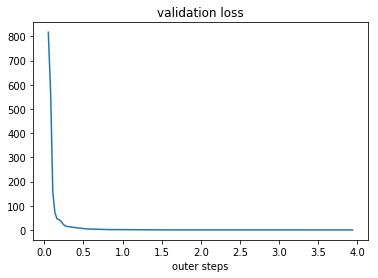

In [16]:
K = 150
eval_interval = 10
T = 20
beta = 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time = 0,  [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.fixed_point(params, hparams, T, map_func, outer_func, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

val_fp = val_losses
run_fp = running_time
    

# AID-CG

outer step=0 (4.97e-02s)(2.01e-02, 2.91e-02) | val loss=817.3919677734375 | hypergrad norm = 2.823e+02
outer step=10 (2.81e-02s)(9.33e-03, 1.85e-02) | val loss=15.051633834838867 | hypergrad norm = 3.509e+00
outer step=20 (2.72e-02s)(9.00e-03, 1.80e-02) | val loss=3.578373908996582 | hypergrad norm = 7.887e-01
outer step=30 (3.04e-02s)(9.57e-03, 2.04e-02) | val loss=1.5752440690994263 | hypergrad norm = 3.452e-01
outer step=40 (2.95e-02s)(9.31e-03, 1.99e-02) | val loss=0.8490216732025146 | hypergrad norm = 1.672e-01
outer step=50 (2.97e-02s)(9.75e-03, 1.96e-02) | val loss=0.5733917951583862 | hypergrad norm = 1.126e-01
outer step=60 (2.73e-02s)(9.02e-03, 1.80e-02) | val loss=0.4172477722167969 | hypergrad norm = 7.682e-02
outer step=70 (2.91e-02s)(9.31e-03, 1.95e-02) | val loss=0.32921773195266724 | hypergrad norm = 5.794e-02
outer step=80 (3.05e-02s)(1.01e-02, 2.02e-02) | val loss=0.27070608735084534 | hypergrad norm = 4.656e-02
outer step=90 (2.96e-02s)(9.53e-03, 1.97e-02) | val loss

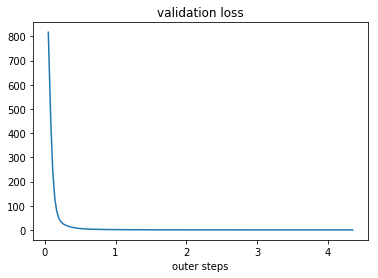

In [17]:
K = 150
eval_interval = 10
T = 20
beta = 0.01 # diverges with 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time = 0,  [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.CG(params, hparams, T, map_func, outer_func, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))


print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

val_cg = val_losses
run_cg = running_time


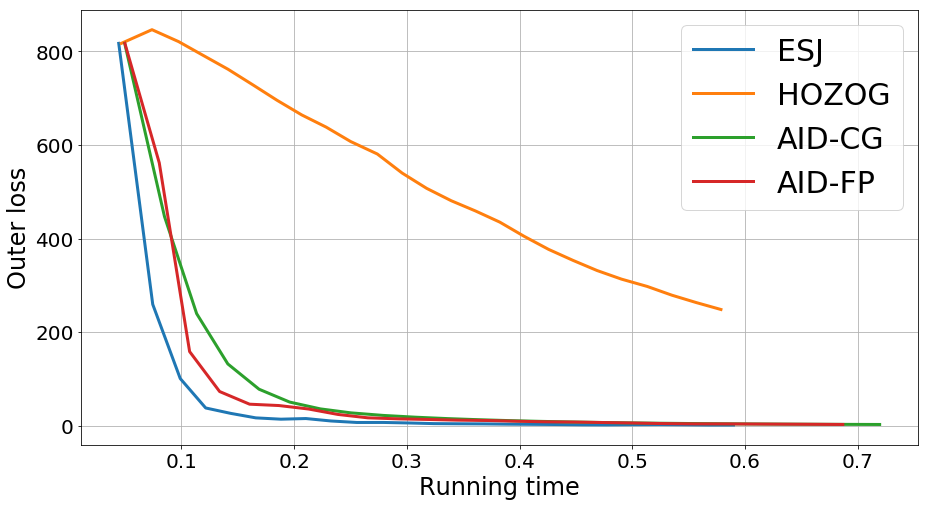

In [18]:
s, s2 = 25, 25
lw = 3

plt.plot(run_zoj[:s2], val_zoj[:s2], '-', label='ESJ', linewidth=lw)
plt.plot(run_hozog[:s2], val_hozog[:s2], '-', label='HOZOG', linewidth=lw)
plt.plot(run_cg[:s], val_cg[:s], '-', label='AID-CG', linewidth=lw)
plt.plot(run_fp[:s], val_fp[:s], '-', label='AID-FP', linewidth=lw)
plt.xlabel('Running time', fontsize=24)
plt.ylabel('Outer loss', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.grid()
plt.legend(loc='upper right', fontsize=30)
plt.gcf().set_size_inches(15, 8)
# plt.savefig('hrl_T20_D256.pdf', bbox_inches='tight', transparent=True, dpi=600)
plt.show()

# Different number T of inner loop steps

outer step=0 (2.96e-02s)(1.64e-02, 1.26e-02) | val loss=508.63787841796875 | hypergrad norm = 3.846e+02
outer step=10 (1.26e-02s)(5.79e-03, 6.74e-03) | val loss=5.386643886566162 | hypergrad norm = 4.129e+01
outer step=20 (1.27e-02s)(5.81e-03, 6.76e-03) | val loss=1.8146494626998901 | hypergrad norm = 2.238e+01
outer step=30 (1.25e-02s)(5.73e-03, 6.71e-03) | val loss=0.7977696061134338 | hypergrad norm = 1.537e+01
outer step=40 (1.26e-02s)(5.76e-03, 6.71e-03) | val loss=0.40675872564315796 | hypergrad norm = 1.075e+01
outer step=50 (1.24e-02s)(5.67e-03, 6.61e-03) | val loss=0.14815568923950195 | hypergrad norm = 6.738e+00
outer step=60 (1.25e-02s)(5.73e-03, 6.69e-03) | val loss=0.07873979210853577 | hypergrad norm = 4.573e+00
outer step=70 (1.23e-02s)(5.62e-03, 6.61e-03) | val loss=0.057468317449092865 | hypergrad norm = 3.979e+00
outer step=80 (1.25e-02s)(5.76e-03, 6.67e-03) | val loss=0.028070863336324692 | hypergrad norm = 2.688e+00
outer step=90 (1.24e-02s)(5.70e-03, 6.61e-03) | va

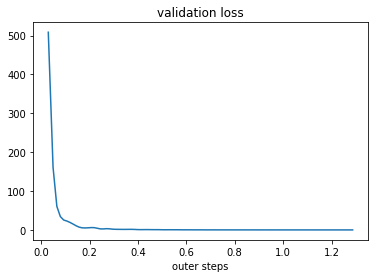

In [5]:
K = 100
eval_interval = 10
T = 20
mu = .01
beta = 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time = 0,  [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvzoj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

val_zoj20 = val_losses
run_zoj20 = running_time



outer step=0 (1.88e-02s)(1.08e-02, 7.65e-03) | val loss=1155.5977783203125 | hypergrad norm = 5.728e+02
outer step=10 (7.11e-03s)(2.98e-03, 4.02e-03) | val loss=22.412263870239258 | hypergrad norm = 8.318e+01
outer step=20 (6.94e-03s)(2.92e-03, 3.92e-03) | val loss=9.328634262084961 | hypergrad norm = 5.384e+01
outer step=30 (7.97e-03s)(3.18e-03, 4.62e-03) | val loss=3.784883499145508 | hypergrad norm = 3.114e+01
outer step=40 (6.91e-03s)(2.92e-03, 3.89e-03) | val loss=1.3932955265045166 | hypergrad norm = 1.918e+01
outer step=50 (6.90e-03s)(2.91e-03, 3.89e-03) | val loss=0.39852824807167053 | hypergrad norm = 1.022e+01
outer step=60 (7.24e-03s)(2.89e-03, 4.24e-03) | val loss=0.14180555939674377 | hypergrad norm = 5.925e+00
outer step=70 (6.91e-03s)(2.94e-03, 3.87e-03) | val loss=0.06238687410950661 | hypergrad norm = 4.113e+00
outer step=80 (6.89e-03s)(2.90e-03, 3.89e-03) | val loss=0.029090922325849533 | hypergrad norm = 2.473e+00
outer step=90 (7.09e-03s)(3.02e-03, 3.96e-03) | val l

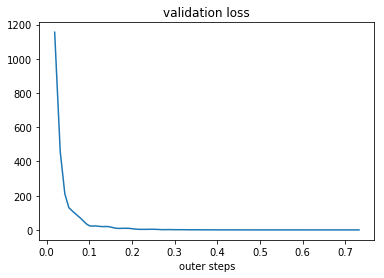

In [6]:
K = 100
eval_interval = 10
T = 10
mu = .01
beta = 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time = 0,  [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvzoj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

val_zoj10 = val_losses
run_zoj10 = running_time


outer step=0 (4.21e-02s)(2.36e-02, 1.82e-02) | val loss=175.12783813476562 | hypergrad norm = 2.326e+02
outer step=10 (2.48e-02s)(1.15e-02, 1.31e-02) | val loss=1.9239643812179565 | hypergrad norm = 2.321e+01
outer step=20 (2.53e-02s)(1.22e-02, 1.29e-02) | val loss=0.6176621913909912 | hypergrad norm = 1.361e+01
outer step=30 (2.51e-02s)(1.21e-02, 1.27e-02) | val loss=0.24652056396007538 | hypergrad norm = 8.091e+00
outer step=40 (2.53e-02s)(1.23e-02, 1.29e-02) | val loss=0.08766528218984604 | hypergrad norm = 4.800e+00
outer step=50 (2.52e-02s)(1.22e-02, 1.28e-02) | val loss=0.04506208002567291 | hypergrad norm = 3.476e+00
outer step=60 (2.51e-02s)(1.22e-02, 1.27e-02) | val loss=0.03296581655740738 | hypergrad norm = 2.876e+00
outer step=70 (2.56e-02s)(1.25e-02, 1.29e-02) | val loss=0.01167237013578415 | hypergrad norm = 1.310e+00
outer step=80 (2.50e-02s)(1.16e-02, 1.32e-02) | val loss=0.00818544253706932 | hypergrad norm = 9.203e-01
outer step=90 (2.49e-02s)(1.16e-02, 1.31e-02) | va

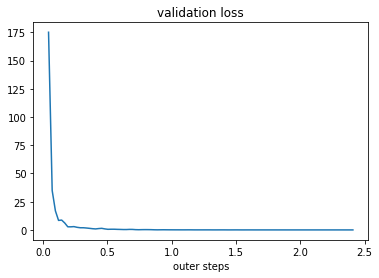

In [7]:
K = 100
eval_interval = 10
T = 40
mu = .01
beta = 0.05

#hparams = [torch.randn((p, d)).requires_grad_(True)]
hparams = [hp.clone() for hp in hp0]
hparams = [hp.requires_grad_(True) for hp in hparams]

outer_opt = torch.optim.Adam(lr=beta, params=hparams)

total_time, val_losses, running_time = 0,  [], []

for k in range(K):
    
    step_start_time = time.time() 
    inner_losses = []
    params = inner_solver(hparams, steps=T)
    t1 = time.time() - step_start_time # inner loop time

    outer_opt.zero_grad()
    _, cost = hg.hgvzoj(params, hparams, outer_func, inner_solver, mu=mu, T=T, p=1, set_grad=True)
    t2 = time.time() - step_start_time - t1 # hypergrad estimation time 
    val_losses.append(cost.item())
    outer_opt.step()
    
    step_time = time.time()-step_start_time
    total_time +=step_time
    running_time.append(total_time)

    if k % eval_interval == 0 or k == K - 1:
        print('outer step={} ({:.2e}s)({:.2e}, {:.2e}) | val loss={} | hypergrad norm = {:.3e}'.format(k, step_time, t1, t2, val_losses[-1], torch.norm(hparams[0].grad)))
        
print('total time = {}'.format(total_time))

plt.title('validation loss')
plt.xlabel('outer steps')
#plt.plot(val_losses)
plt.plot(running_time, val_losses)
plt.show()

val_zoj50 = val_losses
run_zoj50 = running_time




In [11]:
#run_zoj5 = [t * 5 for t in run_zoj5]
run_zoj10 = [t * 5 for t in run_zoj10]
run_zoj20 = [t * 5 for t in run_zoj20]
run_zoj50 = [t * 5 for t in run_zoj50]

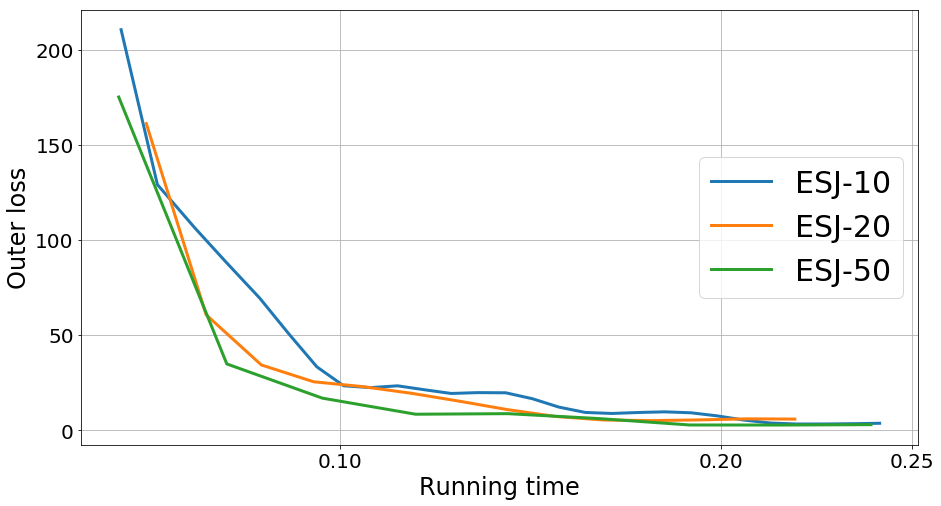

In [11]:
s1 = 9
s2 = 15
s3 = 30

lw = 3
iters = list(range(K))
plt.plot(run_zoj10[2:s3], val_zoj10[2:s3], '-', label='ESJ-10', linewidth=lw)
plt.plot(run_zoj20[1:s2], val_zoj20[1:s2], '-', label='ESJ-20', linewidth=lw)
plt.plot(run_zoj50[:s1], val_zoj50[:s1], '-', label='ESJ-50', linewidth=lw)
#plt.plot(run_fp[1:s2], val_fp[1:s2], '-', label='AID-FP', linewidth=lw)
plt.xlabel('Running time', fontsize=24)
plt.ylabel('Outer loss', fontsize=24)
plt.xticks([0.1, 0.2, 0.25], fontsize=20)
plt.yticks(fontsize=20)
plt.legend(loc='center right', fontsize=30)
plt.grid()
plt.gcf().set_size_inches(15, 8)
plt.savefig('hrlTfinal.pdf', bbox_inches='tight', transparent=True, dpi=600)
plt.show()